# 2. Graph Neural Networks and DGL (Deep Graph Library)

## 2.1 Concept of GNNs

A Graph Neural Network is a Deep Learning architecture that was developed for data that is most naturally represented by a graph. It it's most basic understanding, a graph is a set of nodes that are connected through edges based on some node relations. Here are some examples for how to represent data as graphs: 

- molecules: atoms are nodes and edges represent the bonds 
- social networks: each node is a person and an edge between two nodes exists if two persons know each other
- computer vision: identified objects in an image can be represented by nodes and their relations as edges 
- and many more ... 

In these cases graph representations pose an advantage towards a representation as lists/sequences as they don't impose an artificial ordering of the data that might implement a bias, and it can incorporate relations. Graphs are especially useful in cases of sparse data. For computer vision, considering a case where there are many objects in one image, one can either take the whole image and process it with CNNs, or one identifies the objects first and processes them further, reducing the size of the data from the number of pixels to the number of objects. This can save time, memory, computing ressources and improve efficiency. 

The tasks for GNNs can be:
- node feature predictions: for social networks, predict interests of people based on their connections 
- edge feature predictions: interactions between molecules or proteins, bonds between atoms 
- global prediction (learning a feature of the whole system based on its components and connections): predicting properties of a protein/molecule, this tutorial: classifying jets 

Depending on the task, the overal network structure can vary but the basic principal is given in the image below. We represent the graph as $G = (u,V,E)$ where $u$ is the global representation of the graph, $V$ is the set of nodes and $E$ is the set of edges.


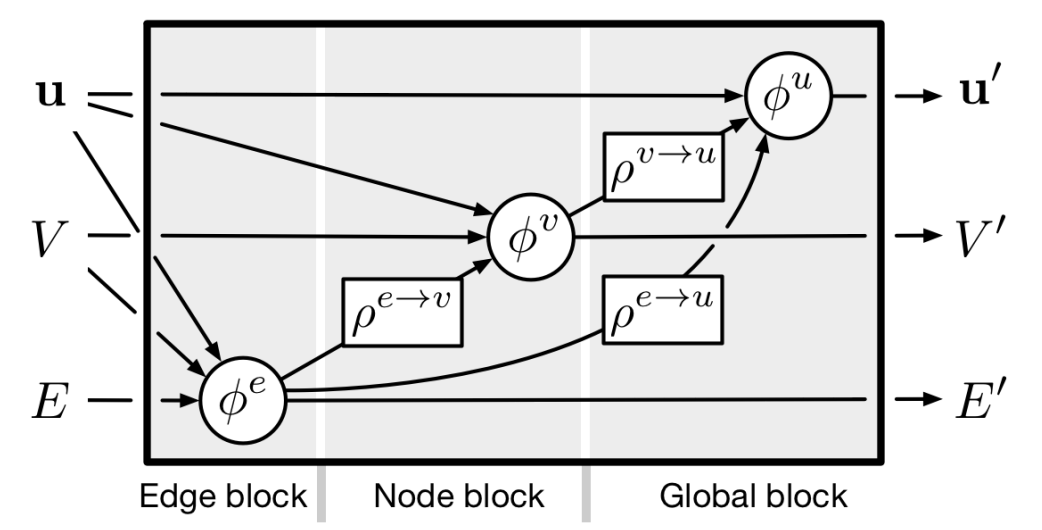

In [2]:
from IPython.display import Image, display
display(Image(filename='img/gnn.png', embed=True, width=600))

$\phi^e$, $\phi^\nu$ and $\phi^u$ are typically simple dense neural networks meant to update the edges, nodes, and global representations. $\rho^{e\rightarrow u}$, $\rho^{e\rightarrow \nu}$ and $\rho^{\nu\rightarrow u}$ are permutation invariant reduction functions to transfer information from edges to nodes, nodes to global and edges to global, usually it is a sum, mean, max or min. 

1. Edge update: Net $\phi^e$ updates the edge representation. The current edge representation, global information and information of nodes connected by the edges are taken as input. 
2. Node update: Net $\phi^\nu$ updates the node representation. The inputs are the current node representation, the global representation and aggregated *updated* edges (for example $\rho^{e\rightarrow \nu}$ can sum all the edge representations that connect to a node). 
3. Global update: Net $\phi^u$ takes the current global representation, the updated node features aggregated through $\rho^{\nu\rightarrow u}$ and the updated edge features aggregated through $\rho^{e\rightarrow u}$.

This is one single GNN block. Typically the whole architecture consists of multiple GNN blocks applied iteratively.

Feel free to read more about the basics of GNNs here: https://distill.pub/2021/gnn-intro/

## 2.2 Deep Graph Library 

DGL is a useful library for working with graphs. It is possible to code a graph neural network completely without it, but the inbuild functions are very convenient and simplify the task significantly. In the following we will get familiar with the package and its most important functions that we will need for our network architecture.

You have to install dgl locally. The dgl version has to be compatible with the cuda version on your device. To check the cuda version type `nvcc --version` in the terminal. Based on the version follow the instructions in https://www.dgl.ai/pages/start.html to install it.

In [6]:
import torch
import dgl 
import numpy as np
import networkx as nx

##### Step 1: Graph creation

For the graph creation you specify the edges. The edges have a direction, they have a source and a destination. So when defining the graph you give an array of source nodes and an array of destination nodes.

In [47]:
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))

Above line created a graph that connects the node 0 to the nodes 1,2,3,4 and 5. We can visualize it using the `networkx` package:

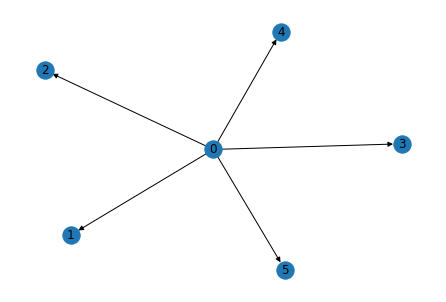

In [28]:
nx.draw(g.to_networkx(), with_labels=True)

In this case the number of nodes was given implicitly, but it can also be specified through the `num_nodes` parameter.

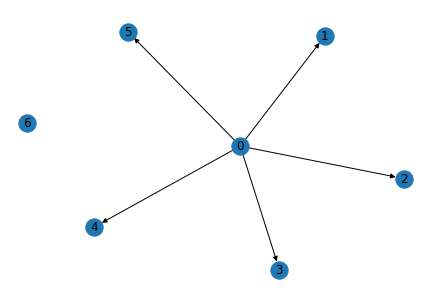

In [29]:
g_ = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=7)
nx.draw(g_.to_networkx(), with_labels=True)

It is possible to add and remove edges afterwards as well. For adding the same notation is used as during the creation, i.e. two lists for source and destination. For the removal we only specify the index (or list of edge indeces) of the edge(s) to be removed.

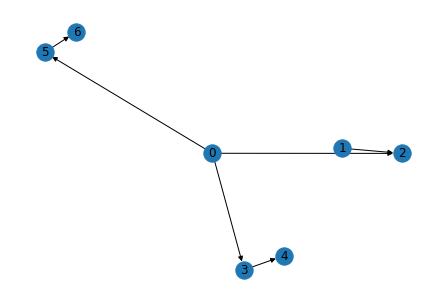

In [48]:
g.add_edges([1,3,5],[2,4,6])
g.remove_edges([0,3])
nx.draw(g.to_networkx(), with_labels=True)

In many applications edges don't have a direction. In that case we can transfer the graph to a bidirected one. Effectively this will double the number the egdes. 

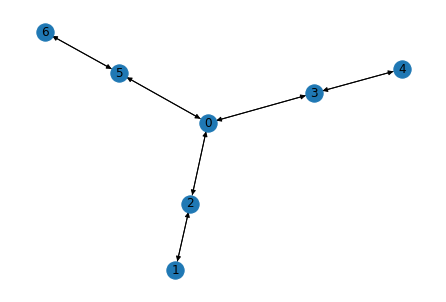

In [49]:
g = dgl.to_bidirected(g)
nx.draw(g.to_networkx(), with_labels=True)

##### Step 2: Assigning features 
Now we want to assign features to the nodes and edges of the graph. 

In [52]:
# we have 7 nodes and feature x has 3 dimensions 
g.ndata['x'] = torch.randn(7, 3)
# we can also add feature y which is a 5x4 tensor
g.ndata['y'] = torch.randn(7, 5, 4)
# edge feature z is a 2d tensor
g.edata['z'] = torch.randn(g.num_edges(), 2)

It is possible to have different types of nodes with a `heterograph`. This is useful in case you have different objects in the graph. For example when making a graph from social media data a person can follow a person or a topic, so that in this case topics and people will be represented as different nodes. Different network parts can act seperately on different nodes.

Even if our data has only one type of nodes we might still want the heterograph to implement the global node. 

In the following lets assume we have a group of school kids and subjects that they like. And we have a global representation that can contain some information on the group dynamic. 

We create a dictionary to implement the names of node and edge types as tuples of the form (source type, edge name, destination type). We consider 4 kids and 3 subjects.

In [101]:
graph_dict = {
    ('kid', 'is-friend', 'kid'): (torch.tensor([0, 1, 1, 2, 2, 3]), torch.tensor([1, 0, 2, 1, 3, 2])),
    ('kid', 'likes', 'subject'): (torch.tensor([0, 1, 2, 3, 0]), torch.tensor([0,0,1,1,2])),
    ('kid', 'kid_to_global', 'global'): (torch.tensor([0, 1, 2, 3]), torch.tensor([0, 0, 0, 0]))
}

g = dgl.heterograph(graph_dict)

Note that since the function `dgl.to_bidirected(g)` is not well defined for heterogenous graphs, you need to specify the edges that go in both directions by hand.

Now we can add feature specifying the node names:

In [102]:
g.nodes['kid'].data['age'] = torch.tensor([5, 7, 11, 6]).float()
g.nodes['kid'].data['grades'] = torch.tensor([[95,86,70], [98, 89, 78], [85, 90, 88], [88, 87, 91]])
g.nodes['global'].data['x'] = torch.rand(1, 10)

##### Step 3: Functions on the graph

For our network we will later use a "Message Passing Neural Network". The working principal of message passing consists of 3 steps and is illustarted in the sketch below: 
1. Propagation: passing the information from all connected nodes 
2. Aggregation: collect all the information 
3. Update: Using a neural network to update the node representation by using the aggregted information (later)

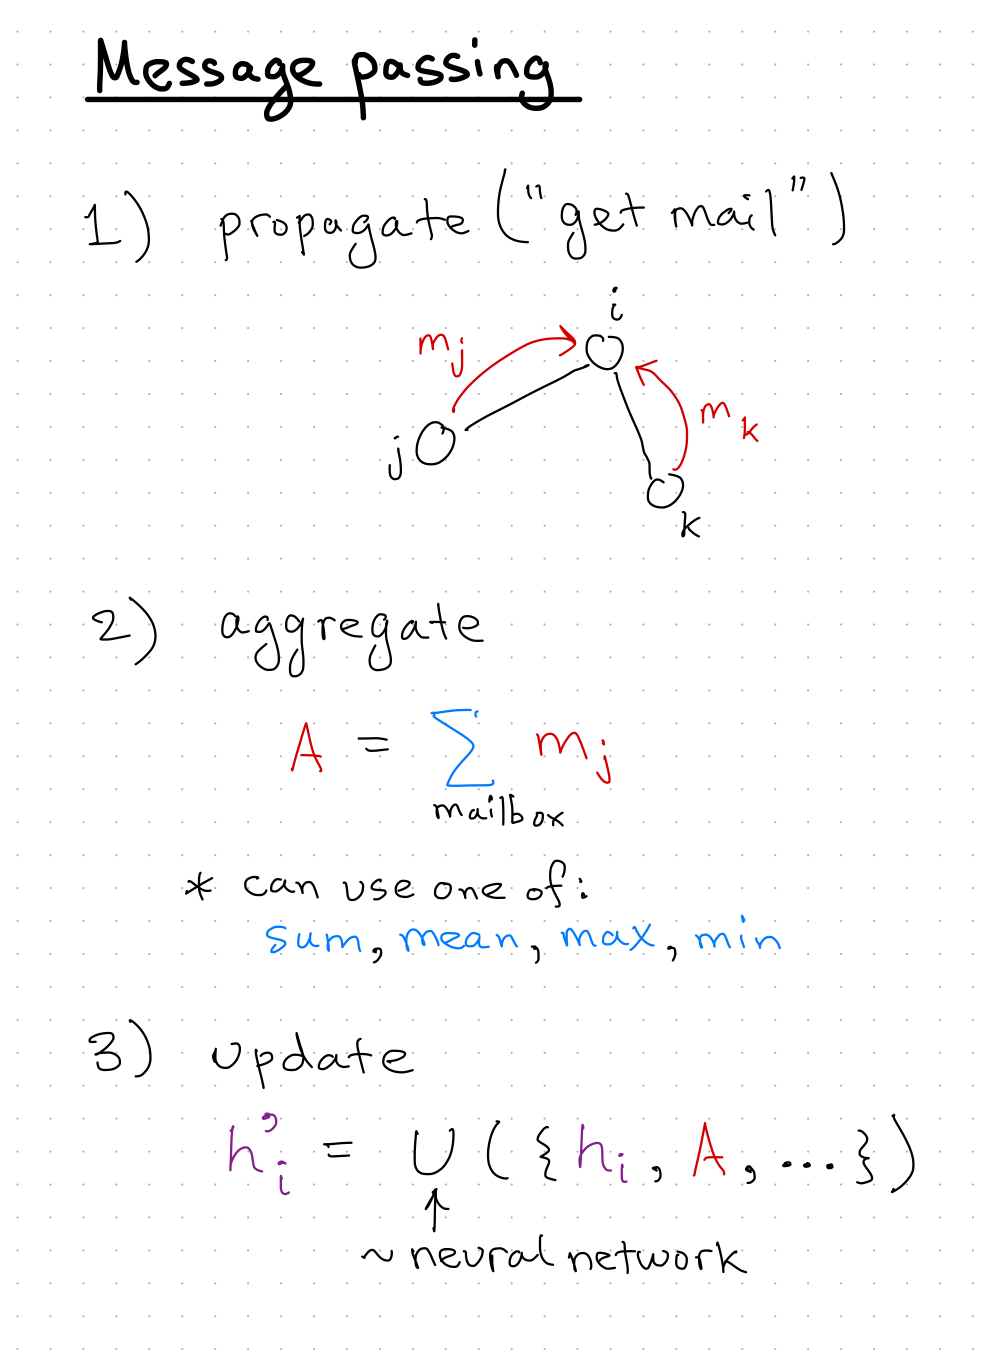

In [111]:
from IPython.display import Image, display
display(Image(filename='img/messages.jpeg', embed=True, width=420))

The DGL has the `update_all` function where you can specify the functions you want to use for propagation and aggregation. Let's say we want to pass node data to the connecting neighbours and sum it. From a technical point of view, for the propagation we can simply copy the node data on the edges and in the aggregation for every node we sum the information from the edges that are connected to it.

In [103]:
import dgl.function as fn

g.update_all(
    fn.copy_u('age', 'm'), # propagation: copy 'age' as message 'm'
    fn.sum('m', 'age_sum'), # aggregation: sum the messages as 'age_sum'
    etype='is-friend'
    )

print(g.nodes['kid'].data['age_sum'])

tensor([ 7., 16., 13., 11.])


We can also customize our propagation and aggregation functions. Note that only within the edge function you can access the information with `edges.src[node_feature_name]` or `edges.dst[node_feature_name]`. In the nodes function we can access the message through `nodes.mailbox[edge_feature_name]` where `egde_feature_name` was created in the propagation function.

In [109]:
def propagate(edges):
    grades = edges.src['grades'] # has shape E x 3
    age = edges.src['age'].unsqueeze(1) # has shape E -> unsqueeze to E x 1

    # the message is the product of the grades and age
    grades_times_age = grades * age # has shape E x 3
    print(grades_times_age)
    return {'grades_times_age': grades_times_age}

def aggregate(nodes):

    mail = nodes.mailbox['grades_times_age'] # can have different shapes depending on the number of neighbors
    mail = mail.sum(dim=1) 
    return {'mail': mail}

g.update_all(propagate, aggregate, etype='likes')

print(g.nodes['subject'].data['mail'])    

tensor([[475., 430., 350.],
        [686., 623., 546.],
        [935., 990., 968.],
        [528., 522., 546.],
        [475., 430., 350.]])
tensor([[1161., 1053.,  896.],
        [1463., 1512., 1514.],
        [ 475.,  430.,  350.]])


The beauty of this is that you don't have to deal internally with the graph and its edges and the dgl function takes care of it for you! 

One more useful function is `dgl.broadcast_nodes` it can add data to all nodes of a certain type. For example, when updating the nodes you might want to use the global information, you can easily copy the global information to the nodes with the following step:

In [110]:
g.nodes['kid'].data['h'] = dgl.broadcast_nodes(g, g.nodes['global'].data['x'], ntype= 'kid')
print(g.nodes['kid'].data['h'])

tensor([[0.0157, 0.1729, 0.9478, 0.3108, 0.4051, 0.4178, 0.2187, 0.5872, 0.6874,
         0.6210],
        [0.0157, 0.1729, 0.9478, 0.3108, 0.4051, 0.4178, 0.2187, 0.5872, 0.6874,
         0.6210],
        [0.0157, 0.1729, 0.9478, 0.3108, 0.4051, 0.4178, 0.2187, 0.5872, 0.6874,
         0.6210],
        [0.0157, 0.1729, 0.9478, 0.3108, 0.4051, 0.4178, 0.2187, 0.5872, 0.6874,
         0.6210]])


You can find more information browsing through the DGL users guide https://docs.dgl.ai/.

### Exercise 

1. Construct a bidirected graph of the molecule of ethanoic acid shown below including the following features:
    - node data: atomic number, atomic mass, number of bonds 
    - edge data: bond type (is it a double bond or a single bond)
    
    Draw the graph.
    
    Note: `dgl.to_bidirected` doesn't transfer the edge data to the 'duplicated' edges. You have to define the edges in both direction by hand.

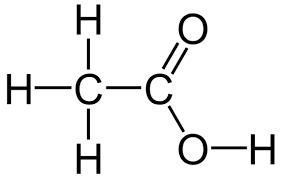

In [126]:
from IPython.display import Image, display
display(Image(filename='img/ethanoic_acid.png', embed=True, width=300))

2. Make a linear layer that takes the node data (atomic number, atomic mass, n_bonds) and creates a node representation of size 10. Add the representation as node feature to the graph. (No training.)

3. Write an edge function that takes the node representation from the source node together with the bond type and passes it through another linear layer creating an edge representation of size 15. (In the edge function you can access edge information via `edges.data[...]`)

4. Write a node function that aggregates the edge represenations using the mean, combines the current node representation with the aggregated edge represantion, passes it through another linear layer that creates a new node representation and overwrites the previous one.

5. Use the `update_all` function to implement 3. and 4.

6. Sum the new node representation of all nodes to get a global representation. You can use the function `dgl.sum_nodes`. Add the global representation as node feature.